In [302]:
# implementation from stackoverflow.
# See https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362

import numpy as np


class real_time_peak_detection():
    def __init__(self, array, lag, threshold, influence):
        self.y = list(array)
        self.length = len(self.y)
        self.lag = lag
        self.threshold = threshold
        self.influence = influence
        self.signals = [0] * len(self.y)
        self.filteredY = np.array(self.y).tolist()
        self.avgFilter = [0] * len(self.y)
        self.stdFilter = [0] * len(self.y)
        self.avgFilter[self.lag - 1] = np.mean(self.y[0:self.lag]).tolist()
        self.stdFilter[self.lag - 1] = np.std(self.y[0:self.lag]).tolist()

    def thresholding_algo(self, new_value):
        self.y.append(new_value)
        i = len(self.y) - 1
        self.length = len(self.y)
        if i < self.lag:
            return 0
        elif i == self.lag:
            self.signals = [0] * len(self.y)
            self.filteredY = np.array(self.y).tolist()
            self.avgFilter = [0] * len(self.y)
            self.stdFilter = [0] * len(self.y)
            self.avgFilter[self.lag] = np.mean(self.y[0:self.lag]).tolist()
            self.stdFilter[self.lag] = np.std(self.y[0:self.lag]).tolist()
            return 0

        self.signals += [0]
        self.filteredY += [0]
        self.avgFilter += [0]
        self.stdFilter += [0]

        if abs(self.y[i] - self.avgFilter[i - 1]) > (self.threshold * self.stdFilter[i - 1]):

            if self.y[i] > self.avgFilter[i - 1]:
                self.signals[i] = 1
            else:
                self.signals[i] = -1

            self.filteredY[i] = self.influence * self.y[i] + \
                (1 - self.influence) * self.filteredY[i - 1]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])
        else:
            self.signals[i] = 0
            self.filteredY[i] = self.y[i]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])

        return self.signals[i]

In [303]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(os.getcwd(), "data/20240603/LW-2_20240603_180436_243.csv"), skiprows=11)
df["FreeAccMagnitude"] = (df["FreeAcc_X"]**2 + df["FreeAcc_Y"]**2 + df["FreeAcc_Z"]**2)**0.5

<Axes: >

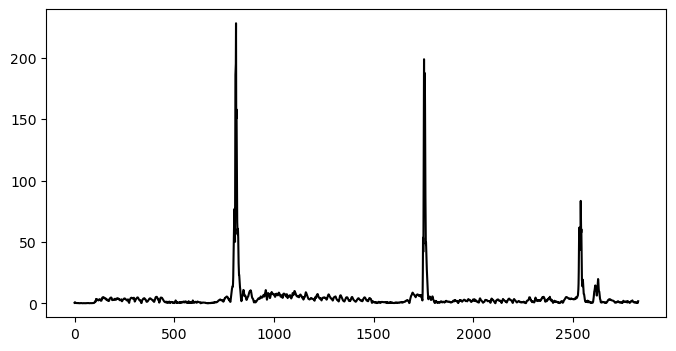

In [304]:
df["FreeAccMagnitude"].plot(figsize=(8, 4), c='black')

In [305]:
values = df["FreeAccMagnitude"].to_list()

lag = 50
threshold = 5
influence = 0.1

d = real_time_peak_detection(values[0:lag], lag, threshold, influence)

for value in values[lag:]:
  d.thresholding_algo(value)

df["Anomaly"] = d.signals

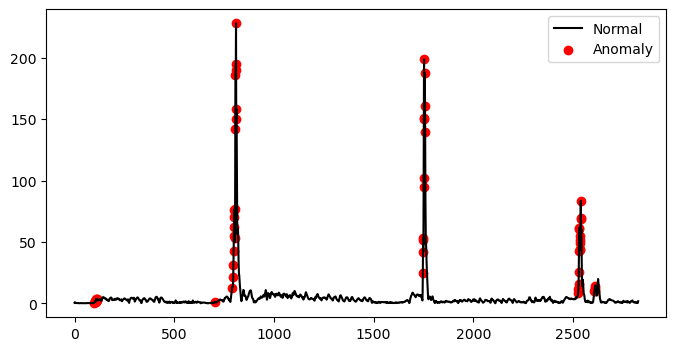

In [306]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
#anomalies = df.loc[(df['Anomaly'] == 1) & (df['FreeAccMagnitude'] > 5), ['FreeAccMagnitude']]  # Anomaly
anomalies = df.loc[df['Anomaly'] == 1, ['FreeAccMagnitude']]  # Anomaly
ax.plot(df.index, df['FreeAccMagnitude'], color='black', label='Normal')
ax.scatter(anomalies.index, anomalies['FreeAccMagnitude'], color='red', label='Anomaly')
plt.legend()
plt.show()